<a href="https://colab.research.google.com/github/Salty-duck0/Flower-Image-generation-using-GAN-model/blob/main/GAN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [ ]:
IMAGE_SIZE = 128
IMAGE_CHANNELS = 3

SEED_SIZE = 100

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

Trained = 370
DATA_PATH = '/content/drive/My Drive/GAN'
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{IMAGE_SIZE}_{IMAGE_SIZE}_-1_to_1.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  img_path = os.path.join(DATA_PATH,'Data')
  for filename in tqdm(os.listdir(img_path)):
      path = os.path.join(img_path,filename)
      image = Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = (training_data / 127.5) -1


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/GAN/training_data_128_128_-1_to_1.npy
Loading previous training pickle...


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))


    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))


    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model
image_shape = (IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS)
discriminator = build_discriminator(image_shape)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(labels, pred):
  labels = labels +0.05 * tf.random.uniform(tf.shape(labels))
  return cross_entropy(labels,pred)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output)+0.05 * tf.random.uniform(tf.shape(fake_output)), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(0.00015,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00015,0.5)

In [ ]:
checkpoint_dir = os.path.join(DATA_PATH, "model")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [ ]:
def save_images(cnt,noise):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (IMAGE_SIZE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (IMAGE_SIZE+PREVIEW_MARGIN)), IMAGE_CHANNELS),
      255, dtype=np.uint8)
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (IMAGE_SIZE+16) + PREVIEW_MARGIN
        c = col * (IMAGE_SIZE+16) + PREVIEW_MARGIN
        image_array[r:r+IMAGE_SIZE,c:c+IMAGE_SIZE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
@tf.function
def train_step(images):
  BATCH_SIZE = tf.shape(images)[0]
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
    pred = tf.concat([real_output,fake_output],axis = 0)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(labels,pred)


    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = tf.random.normal([PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE])
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch + Trained,fixed_seed)
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      print("Model Saved")
  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
train(train_dataset, 1)

Epoch 1, gen loss=6.649742603302002,disc loss=0.1607021689414978, 0:03:15.34
1/1 [==============================] - 3s 3s/step
Training time: 0:03:22.02


tf.Tensor([[0.3677447]], shape=(1, 1), dtype=float32)


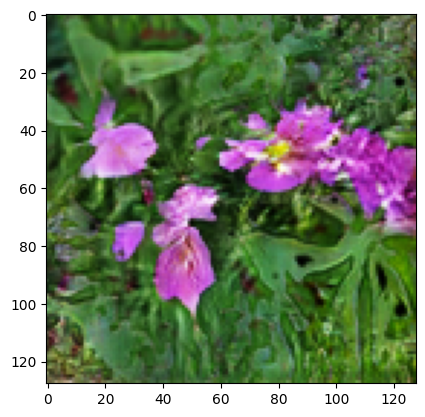

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)*0.5  + 0.5
decision = discriminator(generated_image)
print (decision)
plt.imshow(generated_image[0,:,:,:])

In [ ]:
generator.save(os.path.join(DATA_PATH,'model.h5'))